In [3]:
import re

import ebooklib
from ebooklib import epub
import nltk
from bs4 import BeautifulSoup

In [6]:
import altair as alt
from vega_datasets import data

In [40]:
book = epub.read_epub('../books/free/Great Expectations - Charles Dickens.epub')
items = book.get_items_of_type(ebooklib.ITEM_DOCUMENT)

d = {}
for item in items:
    name = item.get_name()
    content = item.get_body_content()
    soup = BeautifulSoup(content)
    text = soup.get_text()
    d[name] = text

In [41]:
sections = list(d.keys())
sections

['@public@vhost@g@gutenberg@html@files@1400@1400-h@1400-h-0.htm.html',
 '@public@vhost@g@gutenberg@html@files@1400@1400-h@1400-h-1.htm.html',
 '@public@vhost@g@gutenberg@html@files@1400@1400-h@1400-h-2.htm.html',
 '@public@vhost@g@gutenberg@html@files@1400@1400-h@1400-h-3.htm.html',
 '@public@vhost@g@gutenberg@html@files@1400@1400-h@1400-h-4.htm.html',
 '@public@vhost@g@gutenberg@html@files@1400@1400-h@1400-h-5.htm.html',
 '@public@vhost@g@gutenberg@html@files@1400@1400-h@1400-h-6.htm.html',
 '@public@vhost@g@gutenberg@html@files@1400@1400-h@1400-h-7.htm.html',
 '@public@vhost@g@gutenberg@html@files@1400@1400-h@1400-h-8.htm.html',
 '@public@vhost@g@gutenberg@html@files@1400@1400-h@1400-h-9.htm.html',
 '@public@vhost@g@gutenberg@html@files@1400@1400-h@1400-h-10.htm.html',
 '@public@vhost@g@gutenberg@html@files@1400@1400-h@1400-h-11.htm.html',
 '@public@vhost@g@gutenberg@html@files@1400@1400-h@1400-h-12.htm.html',
 '@public@vhost@g@gutenberg@html@files@1400@1400-h@1400-h-13.htm.html',
 '

In [44]:
section = sections[2]
section

'@public@vhost@g@gutenberg@html@files@1400@1400-h@1400-h-2.htm.html'

In [45]:
text = d[section]
text[:200]

'\n\n\n\nChapter VII\nAt the time when I stood in the churchyard reading the family tombstones, I had just enough learning to be able to spell them out. My construction even of their simple meaning was not '

In [5]:
sentence = text.split("\n\n")[1].split(".")[0]
sentence

'THE DAY IN 1948 when Ma Sih Hsuin gets his third-class ticket for a crossing to San Francisco, his father starts addressing him in English'

In [6]:
tokens = nltk.word_tokenize(sentence)
tagged = nltk.pos_tag(tokens)
entities = nltk.chunk.ne_chunk(tagged)

In [7]:
tagged[:5]

[('THE', 'DT'), ('DAY', 'NNP'), ('IN', 'NNP'), ('1948', 'CD'), ('when', 'WRB')]

In [8]:
 nltk.help.upenn_tagset('NNP')

NNP: noun, proper, singular
    Motown Venneboerger Czestochwa Ranzer Conchita Trumplane Christos
    Oceanside Escobar Kreisler Sawyer Cougar Yvette Ervin ODI Darryl CTCA
    Shannon A.K.C. Meltex Liverpool ...


In [9]:
trees = [x for x in entities if type(x) == nltk.tree.Tree]
trees

[Tree('PERSON', [('Ma', 'NNP'), ('Sih', 'NNP'), ('Hsuin', 'NNP')]),
 Tree('GPE', [('San', 'NNP'), ('Francisco', 'NNP')]),
 Tree('GPE', [('English', 'NNP')])]

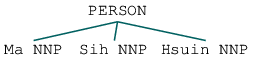

In [10]:
t = trees[0]
t

In [11]:
t.label()

'PERSON'

In [12]:
t.leaves()

[('Ma', 'NNP'), ('Sih', 'NNP'), ('Hsuin', 'NNP')]

In [13]:
for match in re.finditer(r"\bMa\b", text):
    print(match)
    start = match.start() - 20
    end = match.end() + 20
    
    print(text[start:end])
    print()

<re.Match object; span=(31, 33), match='Ma'>
HE DAY IN 1948 when Ma Sih Hsuin gets his 

<re.Match object; span=(564, 566), match='Ma'>
 be seen. But then, Ma Sih Hsuin is not po

<re.Match object; span=(1154, 1156), match='Ma'>
 we have outlasted. Ma resilience!”
Ma Sho

<re.Match object; span=(1170, 1172), match='Ma'>
ed. Ma resilience!”
Ma Shouying gazes out 

<re.Match object; span=(1247, 1249), match='Ma'>
 the calamities the Ma Trading Company has

<re.Match object; span=(2961, 2963), match='Ma'>
ans. They promise.”
Ma Shouying crosses ba

<re.Match object; span=(3500, 3502), match='Ma'>
ain: generations of Ma family profit, from

<re.Match object; span=(3574, 3576), match='Ma'>
 into movable form.
Ma Shouying rakes thro

<re.Match object; span=(8221, 8223), match='Ma'>
cardboard suitcase, Ma Sih Hsuin takes the

<re.Match object; span=(9600, 9602), match='Ma'>
ame. He’s Sih Hsuin Ma now—his old self tu

<re.Match object; span=(9976, 9978), match='Ma'>
ver his papers. “Is Ma your

In [14]:
# name = r"\bHoel\b"
# name = r"\bMa\b"
name = r"[19]\d\d"

In [15]:
for section in d.keys():
    print("========")
    print(section)
    
    c = d[section]
    soup = BeautifulSoup(c)
    text = soup.get_text()

    for match in re.finditer(name, text):
        print(match)
        start = match.start() - 20
        end = match.end() + 20

        print(text[start:end])
        print()

cover.xhtml
toc.xhtml
title.xhtml
<re.Match object; span=(92, 95), match='192'>
nt Publishers Since 1923
NEW YORK   •   LON

ch1.xhtml
ch2.xhtml
<re.Match object; span=(13151, 13154), match='190'>
irst day of spring, 1903, John Hoel positio

<re.Match object; span=(14151, 14154), match='190'>
 again on March 21, 1904, as if he, too, mi

<re.Match object; span=(19758, 19761), match='194'>
never disappear. By 1940, the fungus takes 

<re.Match object; span=(22879, 22882), match='196'>
er cold of February 1965, the No. 2 Brownie

ch3.xhtml
<re.Match object; span=(21, 24), match='194'>
MIMI MA

THE DAY IN 1948 when Ma Sih Hsuin 

<re.Match object; span=(1390, 1393), match='191'>
ons by typhoon. The 1911 revolution and the

<re.Match object; span=(1855, 1858), match='194'>
 students in all of 1948 to be granted visa

<re.Match object; span=(10246, 10249), match='192'>
ng down November 7, 1925. In fact, he was b

<re.Match object; span=(13532, 13535), match='196'>
morning, midsummer, 1967, w

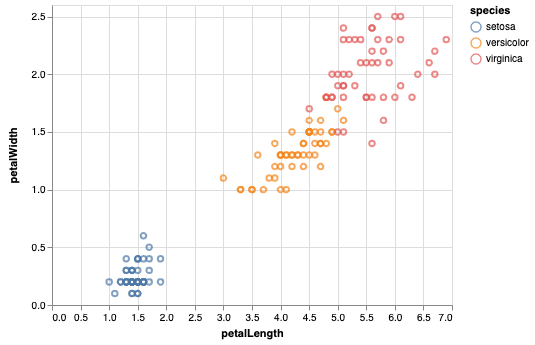

In [16]:
import altair as alt
from vega_datasets import data

iris = data.iris()

alt.Chart(iris).mark_point().encode(
    x='petalLength',
    y='petalWidth',
    color='species'
)